In [1]:
import torch
import matplotlib.pyplot as plt
from src.data import parse_nerf_synthetic, ImagesDataset, NerfData
from src.core import RayMarcherAABB, ContractionAABB
from pathlib import Path

In [2]:
def mip360_contract(coords: torch.Tensor) -> torch.Tensor:
    """Scene contraction from Mip-NeRF 360 https://arxiv.org/abs/2111.12077"""
    norm = torch.norm(coords, dim=-1, keepdim=True) # type: ignore
    return torch.where(norm <= 1., coords, (2. - 1./norm) * coords / norm) / 2.

def clipped_exponential_stepping(near: float, far: float, delta_min: float, delta_max: float, device: torch.device):
    """Clipped exponential stepping function as described in Instant-NGP paper"""
    t = near
    acc_ts, acc_steps = [t], []
    while t < far:
        step = min(delta_max, max(delta_min, t))
        t += step
        acc_ts.append(t)
        acc_steps.append(step)
    ts = torch.tensor(acc_ts[:-1], device=device)
    steps = torch.tensor(acc_steps, device=device)
    return ts, steps

def uniform_stepping(near: float, far: float, n_samples: float, device: torch.device):
    """uniform steps"""
    ts = torch.linspace(near, far, n_samples+1, device=device)
    steps = ts[1:] - ts[:-1]
    return ts[:-1], steps

def unbounded_stepping(near: float, uniform_range: float, n_samples: int, device: torch.device):
    """uniform steps between near and near+uniform_range, then uniform disparity steps
    n_samples//2 samples are used for uniform range, n_samples//2 for disparity range"""
    ts = torch.linspace(0., 1., n_samples , device=device)
    f = lambda x: torch.where(x < 0.5, 2 * x, 1 / (2 - 2 * x))
    ts = f(ts) * uniform_range + near
    steps = ts[1:] - ts[:-1]
    return ts[:-1], steps

In [4]:
data = parse_nerf_synthetic(Path("data/lego"), "train")
img_dataset = ImagesDataset(data)


In [7]:
positions = torch.tensor([M[:3, 3].tolist() for M in data.cameras])
scene_scale = torch.max(torch.var(positions, 0))
aabb = torch.tensor([[-2.,-2.,0.],[2.,2.,2.]])
factor = 80
camera = 20
rays_o = img_dataset[camera]['rays_o'][::factor,::factor].reshape(-1,3)
rays_d = img_dataset[camera]['rays_d'][::factor,::factor].reshape(-1,3)
marcher = RayMarcherAABB(aabb)
contraction = ContractionAABB(aabb)
t_values, _ = marcher(rays_o, rays_d)
samples = rays_o[:,None,:] + rays_d[:,None,:] * t_values[...,None]
_, mask = contraction(samples)
samples = samples[mask]
# samples = samples[:,:100,:]
samples = samples.reshape(-1,3)
# samples = mip360_contract(samples)
# positions = mip360_contract(positions)
print(mask.sum()/mask.numel())

tensor(0.4967)


In [8]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(positions[:,0], positions[:,1], positions[:,2], c='b')
ax.scatter(samples[:,0], samples[:,1], samples[:,2], c='r')
plt.show()

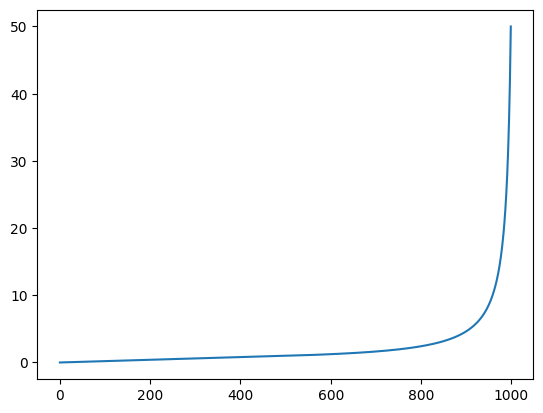

In [13]:
f_inv = lambda x: torch.where(x < 0.5, 2 * x, 1 / (2 - 2 * x))
t = torch.linspace(0.,0.99, 1000)
y = f_inv(t)
plt.plot(y)
plt.show()

In [ ]:
x = torch.randn(40,45,3)
t = torch.randn(40,45)
x * t[...,None]